In [1]:
import xgboost as xgb
import sys, os
sys.path.append(os.path.abspath('..'))
from ift6758.data.feature_engineering_one import feature_engineering_one
from ift6758.data.feature_engineering_pt2  import feature_engineering_two
import ift6758.data.advanced_models as adv
from sklearn.calibration import CalibratedClassifierCV

In [2]:
df = feature_engineering_one(years = range(2016, 2020))
df.head(10)

100%|██████████| 5198/5198 [01:00<00:00, 86.15it/s]


,game_id,season,game_time,period,period_time,event_type,team_id,team_name,coordinates_x,coordinates_y,...,goalie,shot_type,empty_net,strength,situation_code,zone_code,distance_to_net,shot_angle,is_goal,is_empty_net
0,2016020594,20162017,2017-01-08 00:00:00+00:00,1,00:15,shot,8,Canadiens,36.0,-23.0,...,Frederik Andersen,wrist,False,Even Strength,1551,O,57.775427,23.459024,0,0
1,2016020594,20162017,2017-01-08 00:00:00+00:00,1,00:20,goal,8,Canadiens,63.0,0.0,...,Frederik Andersen,wrist,False,Even Strength,1551,O,26.000000,0.000000,1,0
2,2016020594,20162017,2017-01-08 00:00:00+00:00,1,02:34,shot,10,Maple Leafs,-69.0,-16.0,...,Carey Price,wrist,False,Even Strength,1551,O,25.612497,5.782392,0,0
3,2016020594,20162017,2017-01-08 00:00:00+00:00,1,02:45,shot,10,Maple Leafs,-63.0,-12.0,...,Carey Price,wrist,False,Even Strength,1551,O,28.635642,4.513988,0,0
4,2016020594,20162017,2017-01-08 00:00:00+00:00,1,03:47,goal,8,Canadiens,74.0,-9.0,...,Frederik Andersen,snap,False,Even Strength,1551,O,17.492856,30.963757,1,0
5,2016020594,20162017,2017-01-08 00:00:00+00:00,1,05:41,shot,8,Canadiens,66.0,37.0,...,Frederik Andersen,snap,False,Even Strength,1441,O,43.566042,-58.134022,0,0
6,2016020594,20162017,2017-01-08 00:00:00+00:00,1,06:00,shot,8,Canadiens,69.0,-2.0,...,Frederik Andersen,snap,False,Even Strength,1551,O,20.099751,5.710593,0,0
7,2016020594,20162017,2017-01-08 00:00:00+00:00,1,07:21,shot,8,Canadiens,44.0,36.0,...,Frederik Andersen,snap,False,Even Strength,1551,O,57.628118,-38.659808,0,0
8,2016020594,20162017,2017-01-08 00:00:00+00:00,1,08:25,goal,10,Maple Leafs,-76.0,-1.0,...,Carey Price,snap,False,Power Play,1451,O,13.038405,0.347243,1,0
9,2016020594,20162017,2017-01-08 00:00:00+00:00,1,09:13,shot,10,Maple Leafs,-19.0,-24.0,...,Carey Price,snap,False,Even Strength,1551,N,74.000000,12.528808,0,0


In [68]:
from sklearn.model_selection import train_test_split 

X = df[['distance_to_net', 'shot_angle']]
y = df['is_goal']

X_train, X_val, y_train, y_val = train_test_split(
  X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_val)[:, 1]

/Users/qianyunshen/anaconda3/envs/ift-6758-m1/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:18:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7eg2b3w9sf/croot/xgboost-split_1749630922962/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


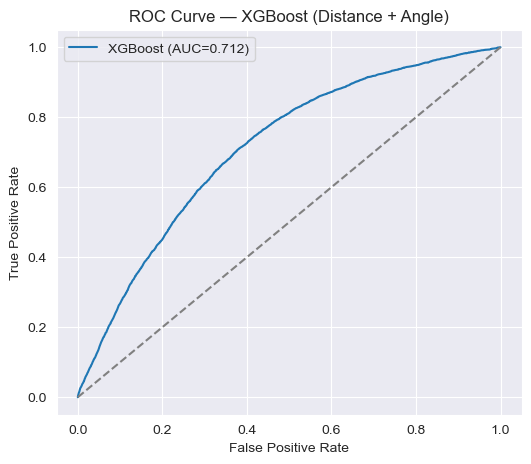

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fpr, tpr, _ = roc_curve(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost (Distance + Angle)")
plt.legend()
plt.show()

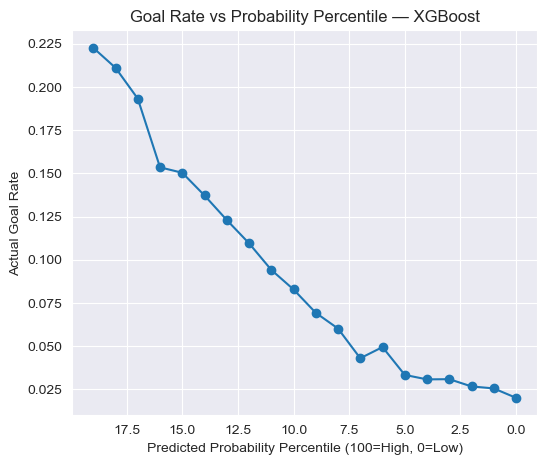

In [71]:
df_val = pd.DataFrame({"y_true": y_val, "y_pred": y_pred})
df_val["percentile"] = pd.qcut(df_val["y_pred"], 20, labels=False)

goal_rate = df_val.groupby("percentile")["y_true"].mean()
plt.figure(figsize=(6,5))
plt.plot(goal_rate.index, goal_rate.values, marker="o")
plt.gca().invert_xaxis()
plt.xlabel("Predicted Probability Percentile (17.5=High, 0=Low)")
plt.ylabel("Actual Goal Rate")
plt.title("Goal Rate vs Probability Percentile — XGBoost")
plt.show()

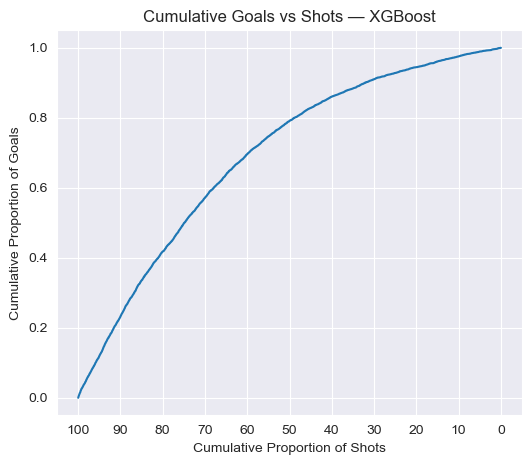

In [75]:
df_sorted = df_val.sort_values("y_pred", ascending=False)
df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
df_sorted["cum_goals_prop"] = df_sorted["cum_goals"] / df_sorted["y_true"].sum()
df_sorted["cum_shots_prop"] = np.arange(1, len(df_sorted)+1) / len(df_sorted)

plt.figure(figsize=(6,5))
plt.plot(df_sorted["cum_shots_prop"], df_sorted["cum_goals_prop"])
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
           [100,90,80,70,60,50,40,30,20,10,0])
plt.xlabel("Cumulative Proportion of Shots")
plt.ylabel("Cumulative Proportion of Goals")
plt.title("Cumulative Goals vs Shots — XGBoost")
plt.show()

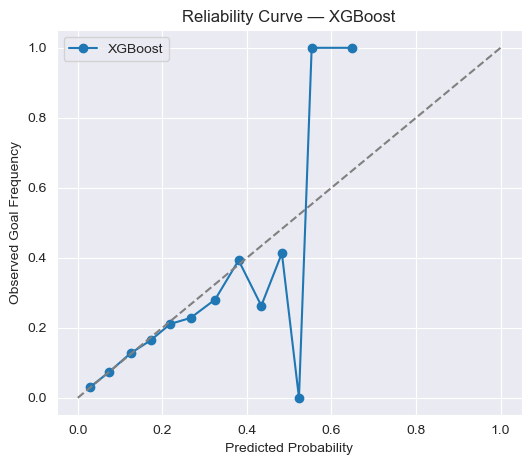

In [7]:
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=20)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="XGBoost")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Goal Frequency")
plt.title("Reliability Curve — XGBoost")
plt.legend()
plt.show()

In [8]:
df2 = feature_engineering_two( years = range(2016, 2020))


In [9]:
df2.describe()

,game_id,season,period,team_id,coordinates_x,coordinates_y,situation_code,previous_event_x,previous_event_y,friendly_skaters,...,current_event_timeseconds,previous_event_timeseconds,time_since_last_event,distance_from_last_event,angle_shot_prev,angle_shot,speed,angle_change,distance_shot,is_goal
count,4.746610e+05,4.746610e+05,474661.000000,474661.000000,474645.000000,474646.000000,474661.000000,461712.000000,461714.000000,474661.000000,...,474661.000000,474661.000000,474661.000000,461700.000000,474656.000000,474644.000000,453503.000000,474651.000000,474644.000000,474661.000000
mean,2.018464e+09,2.018645e+07,2.047480,18.848087,-0.304560,0.034421,1518.499232,-0.179157,0.089293,4.922439,...,590.852442,576.053318,14.799124,62.504793,5.086545,18.342752,7.374078,7.310706,33.729628,0.095875
std,1.733763e+06,1.733911e+04,0.876409,13.845310,63.656842,18.870760,139.462761,65.020993,22.984201,0.469321,...,350.050756,349.974695,22.876902,46.523006,13.087749,19.309057,10.120247,18.160160,19.027438,0.294420
min,2.016020e+09,2.016202e+07,1.000000,1.000000,-99.000000,-42.000000,101.000000,-100.000000,-42.000000,1.000000,...,0.000000,0.000000,-1200.000000,0.000000,0.000000,0.000000,-187.523332,0.000000,0.000000,0.000000
25%,2.017021e+09,2.017202e+07,1.000000,8.000000,-64.000000,-14.000000,1551.000000,-69.000000,-22.000000,5.000000,...,284.000000,269.000000,5.000000,26.400758,0.000000,3.860733,1.977863,0.000000,16.763055,0.000000
50%,2.018021e+09,2.018202e+07,2.000000,17.000000,-4.000000,0.000000,1551.000000,0.000000,0.000000,5.000000,...,583.000000,568.000000,11.000000,47.010637,0.000000,10.765756,4.443810,0.000000,32.202484,0.000000
75%,2.020020e+09,2.020202e+07,3.000000,25.000000,64.000000,14.000000,1551.000000,69.000000,22.000000,5.000000,...,894.000000,879.000000,21.000000,94.260278,1.347887,28.300756,9.439868,2.254575,48.270074,0.000000
max,2.021030e+09,2.021202e+07,8.000000,55.000000,99.000000,42.000000,1560.000000,99.000000,42.000000,6.000000,...,1200.000000,1200.000000,1085.000000,201.109423,90.000000,90.000000,186.625293,177.954592,98.412398,1.000000


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import xgboost as xgb

X = df2[['game_time', 'period','period_time', 'coordinates_x','coordinates_y',
         'distance_shot', 'angle_shot','shot_type','previous_event_name',
         'previous_event_timeperiod','friendly_skaters','opponent_skaters','previous_event_timeseconds',
         'previous_event_x','previous_event_y','distance_from_last_event',
         'rebound','angle_change','speed']]
X = X.copy()
X['rebound'] = X['rebound'].astype(int)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns
median_values = X[numerical_cols].median()

X.loc[:, numerical_cols] = X[numerical_cols].fillna(median_values)
X.loc[:, categorical_cols] = X[categorical_cols].fillna('Unknown')

#change the game_time to second format
X = adv._calculate_time_second(X)
#change the period_time to second format
X = adv._calculate_period_second(X)

X = X.drop(columns=['game_time', 'period_time', 'previous_event_timeperiod'])

y = (df2['event_type'] == 'goal').astype(int)



In [11]:


X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Standardize the numeric columns
exclude_cols = ['shot_type', 'previous_event_name','rebound']
num_cols = [
    col for col in X_train2.columns
    if col not in exclude_cols and X_train2[col].dtype in ['float64', 'int64']
]
scaler = StandardScaler()
X_train2[num_cols] = scaler.fit_transform(X_train2[num_cols])
X_val2[num_cols] = scaler.transform(X_val2[num_cols])
X_train2, ohe = adv.change_to_one_hot(X_train2, ['shot_type', 'previous_event_name'], ohe=None)
X_val2, _ = adv.change_to_one_hot(X_val2, ['shot_type', 'previous_event_name'], ohe=ohe)
X_train2.head(10)

,period,coordinates_x,coordinates_y,distance_shot,angle_shot,friendly_skaters,opponent_skaters,previous_event_timeseconds,previous_event_x,previous_event_y,...,previous_event_name_giveaway,previous_event_name_goal,previous_event_name_hit,previous_event_name_missed-shot,previous_event_name_penalty,previous_event_name_period-end,previous_event_name_period-start,previous_event_name_shot-on-goal,previous_event_name_stoppage,previous_event_name_takeaway
272327,-1.195341,0.947357,-1.273460,0.205366,1.101544,0.165224,0.358098,0.750606,1.515057,0.569644,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59120,1.086790,-0.544915,-1.008580,1.234766,-0.498794,0.165224,0.358098,-0.818022,1.078346,-0.974283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150082,-1.195341,-1.251780,0.050940,-1.295916,-0.932420,0.165224,0.358098,0.470596,-1.074014,0.966653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
294723,2.227856,1.010189,0.156892,-0.449166,-0.595577,-4.103686,-2.985603,-1.418044,-0.543722,0.084410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
415759,-0.054276,-1.078990,-0.107988,-0.715921,-0.912418,0.165224,0.358098,-1.518048,-1.354757,-1.547741,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67241,-1.195341,0.114826,1.640219,2.832221,0.122587,0.165224,0.358098,0.084867,0.002166,-0.003815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
194465,-1.195341,0.067702,-1.220484,2.852842,-0.165794,0.165224,0.358098,-1.018030,-1.229982,-0.268488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95597,-1.195341,1.245811,-0.055012,-1.243690,-0.654215,0.165224,0.358098,-1.040887,1.078346,-0.974283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
473387,-0.054276,1.324351,-0.160964,-1.465247,0.653701,0.165224,0.358098,-1.569478,1.078346,0.966653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242314,-0.054276,-1.267488,-0.160964,-1.322771,-0.897617,0.165224,-1.313752,0.956328,-0.652900,0.040297,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [1, 3, 5],
    'reg_alpha': [0, 0.5, 1]
}

xgb_base = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight = len(y[y==0]) / len(y[y==1])
)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='roc_auc',
    random_state=42
)

search.fit(X_train2, y_train2)

#evaluate the model
best_model = search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val2)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("Best params:", search.best_params_)
print("Best CV AUC:", search.best_score_)
print("Validation AUC:", roc_auc_score(y_val2, y_pred_proba))
print("Validation F1:", f1_score(y_val2, y_pred))
print("Validation Acc:", accuracy_score(y_val2, y_pred))

Best params: {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV AUC: 0.7798136141582169
Validation AUC: 0.7784100970536396
Validation F1: 0.30625557920758084
Validation Acc: 0.6807327272918795


In [13]:
#XGBoost are terrible with calibration! Fixing that by adding this layer on it 
calibrated_xgb = CalibratedClassifierCV(best_model, method='isotonic', cv=5)
calibrated_xgb.fit(X_train2, y_train2)
calibrated_probs = calibrated_xgb.predict_proba(X_val2)[:, 1]
y_pred2 = (calibrated_probs  > 0.5).astype(int)
print("Best params:", search.best_params_)
print("Best CV AUC:", search.best_score_)
print("Validation AUC:", roc_auc_score(y_val2, calibrated_probs))
print("Validation F1:", f1_score(y_val2, y_pred2))
print("Validation Acc:", accuracy_score(y_val2, y_pred2))

Best params: {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV AUC: 0.7798136141582169
Validation AUC: 0.7788677776063652
Validation F1: 0.1043802423112768
Validation Acc: 0.9088936407782331


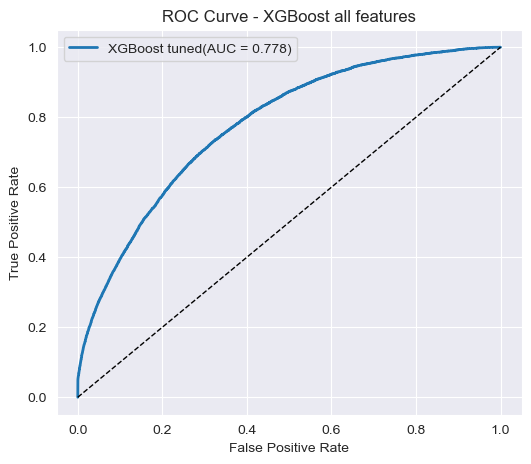

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd

#ROC Curve
fpr, tpr, _ = roc_curve(y_val2, y_pred_proba)
roc_auc = roc_auc_score(y_val2, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost tuned(AUC = {roc_auc:.3f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost all features")
plt.legend()
plt.show()

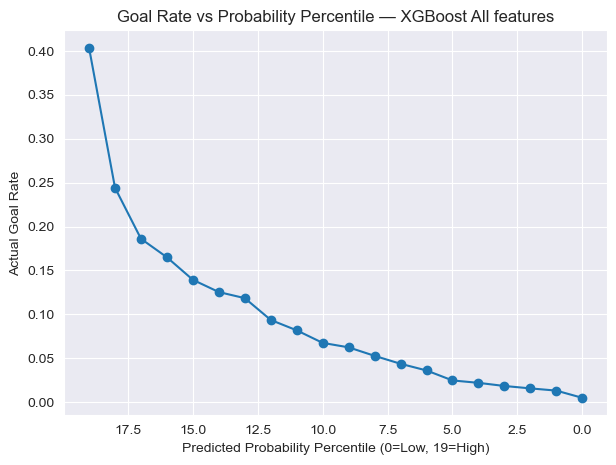

In [77]:
#Goal rate vs probability percentile
df_val = pd.DataFrame({"y_true": y_val2, "y_pred": y_pred_proba})
df_val["percentile"] = pd.qcut(df_val["y_pred"], 20, labels=False)

goal_rate = df_val.groupby("percentile")["y_true"].mean()
plt.figure(figsize=(7,5))
plt.plot(goal_rate.index, goal_rate.values, marker="o")
plt.gca().invert_xaxis()
plt.xlabel("Predicted Probability Percentile (0=Low, 19=High)")
plt.ylabel("Actual Goal Rate")
plt.title("Goal Rate vs Probability Percentile — XGBoost All features")
plt.show()

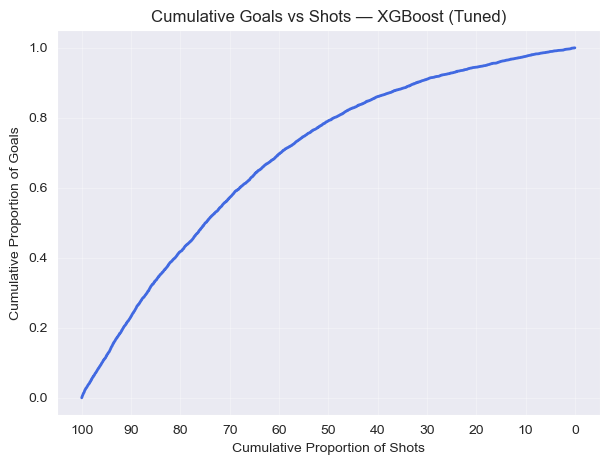

In [76]:
#Cumulative proportion of goals vs probability percentile
import numpy as np
import matplotlib.pyplot as plt

df_sorted = df_val.sort_values("y_pred", ascending=False).reset_index(drop=True)
df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
df_sorted["cum_goals_prop"] = df_sorted["cum_goals"] / df_sorted["y_true"].sum()
df_sorted["cum_shots_prop"] = (np.arange(1, len(df_sorted) + 1)) / len(df_sorted)

plt.figure(figsize=(7, 5))
plt.plot(df_sorted["cum_shots_prop"], df_sorted["cum_goals_prop"], color='royalblue', linewidth=2)
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
           [100,90,80,70,60,50,40,30,20,10,0])
plt.xlabel("Cumulative Proportion of Shots")
plt.ylabel("Cumulative Proportion of Goals")
plt.title("Cumulative Goals vs Shots — XGBoost (Tuned)")
plt.grid(True, alpha=0.3)
plt.show()

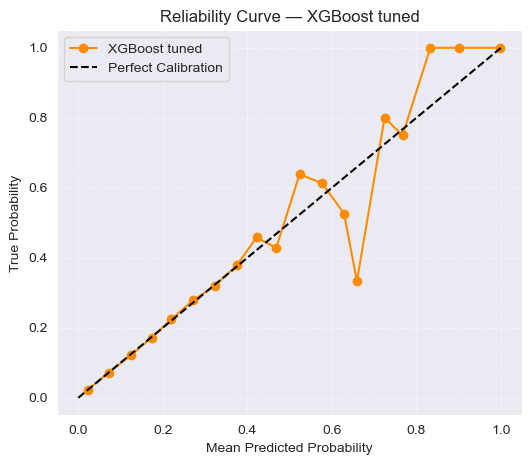

In [17]:
# Reliability curve
prob_true, prob_pred = calibration_curve(y_val2, calibrated_probs, n_bins=20)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, "o-", color="darkorange", label="XGBoost tuned")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("True Probability")
plt.title("Reliability Curve — XGBoost tuned")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [18]:
# to find if two features are highly correlated
import numpy as np
numeric_features = X_train2.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr()
threshold = 0.8
corr_pairs = corr_matrix.unstack()
high_corr = corr_pairs[(abs(corr_pairs) > threshold) & (abs(corr_pairs) < 1)]
high_corr = high_corr.sort_values(ascending=False)
print(high_corr)

previous_event_timeseconds         period_time_seconds                  0.997837
period_time_seconds                previous_event_timeseconds           0.997837
                                   previous_event_timeperiod_seconds    0.997837
previous_event_timeperiod_seconds  period_time_seconds                  0.997837
dtype: float64


In [19]:
redundant_features = [
    'previous_event_timeseconds',
    'previous_event_timeperiod_seconds'
]
X_train_selected = X_train2.drop(columns=redundant_features, errors='ignore')
X_val_selected = X_val2.drop(columns=redundant_features, errors='ignore')

best_model.fit(X_train_selected, y_train2)
y_pred_proba = best_model.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("Validation AUC:", roc_auc_score(y_val2, y_pred_proba))
print("Validation F1:", f1_score(y_val2, y_pred))
print("Validation Acc:", accuracy_score(y_val2, y_pred))

Validation AUC: 0.7789469146111994
Validation F1: 0.3064899451553931
Validation Acc: 0.6803219112426658


In [20]:
from sklearn.feature_selection import VarianceThreshold

# Apply VarianceThreshold 
selector = VarianceThreshold(threshold=0.01)  

selector.fit(X_train2)
X_train_selected = selector.transform(X_train2)
X_val_selected = selector.transform(X_val2)

selected_features = X_train2.columns[selector.get_support()]
removed_features = X_train2.columns[~selector.get_support()]

print(f"\n{len(removed_features)} low-variance features:")
print(list(removed_features))

# Convert back to DataFrame (optional, but helpful for model training)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train2.index)
X_val_selected = pd.DataFrame(X_val_selected, columns=selected_features, index=X_val2.index)

best_model.fit(X_train_selected, y_train2)
y_pred_proba = best_model.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("Validation AUC:", roc_auc_score(y_val2, y_pred_proba))
print("Validation F1:", f1_score(y_val2, y_pred))
print("Validation Acc:", accuracy_score(y_val2, y_pred))


8 low-variance features:
['shot_type_Unknown', 'shot_type_wrap-around', 'previous_event_name_delayed-penalty', 'previous_event_name_game-end', 'previous_event_name_goal', 'previous_event_name_penalty', 'previous_event_name_period-end', 'previous_event_name_period-start']
Validation AUC: 0.7773755027499695
Validation F1: 0.3043697094486388
Validation Acc: 0.6797109540412712


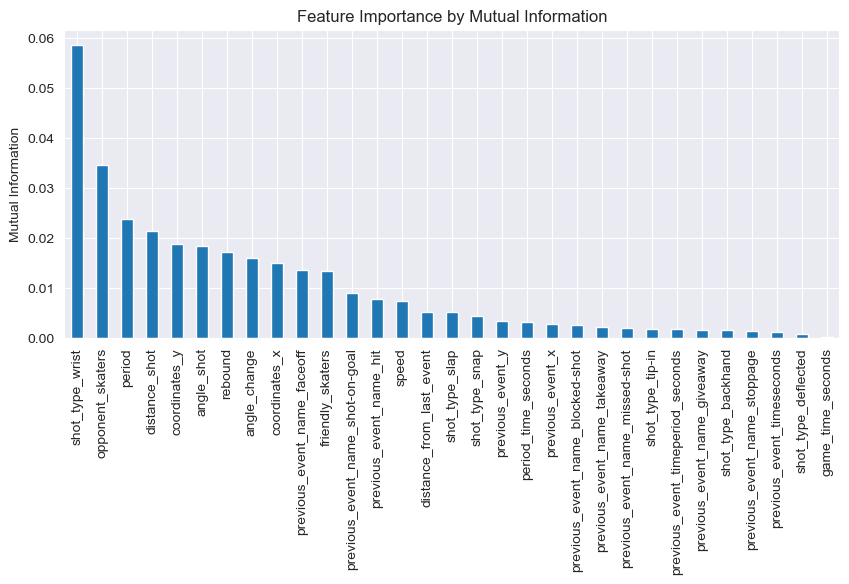

In [21]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train_selected, y_train2, discrete_features='auto')
mi_series = pd.Series(mi, index=X_train_selected.columns).sort_values(ascending=False)


mi_series.plot(kind='bar', figsize=(10,4))
plt.title("Feature Importance by Mutual Information")
plt.ylabel("Mutual Information")
plt.show()

In [22]:
low_importance_feature = ['game_time_second']

def test_feature_drop(features_to_drop):
    X_train_sel = X_train_selected.drop(columns=features_to_drop, errors='ignore')
    X_val_sel = X_val_selected.drop(columns=features_to_drop, errors='ignore')
    best_model.fit(X_train_sel, y_train2)
    y_pred_proba = best_model.predict_proba(X_val_sel)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)
    return {
        'AUC': roc_auc_score(y_val2, y_pred_proba),
        'F1': f1_score(y_val2, y_pred),
        'Acc': accuracy_score(y_val2, y_pred)
    }

# Testing the impact of a single feature
for f in low_importance_feature:
    result = test_feature_drop([f])
    print(f"{f:40s} -> AUC={result['AUC']:.4f}, F1={result['F1']:.4f}, Acc={result['Acc']:.4f}")
X_train_selected = X_train_selected.drop(columns=['game_time_seconds'], errors='ignore')
X_val_selected = X_val_selected.drop(columns=['game_time_seconds'], errors='ignore')

game_time_second                         -> AUC=0.7774, F1=0.3044, Acc=0.6797


In [23]:
#Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# use the best XGBoost model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Create the RFE selector 
selector = RFE(estimator=model, n_features_to_select=25, step=1)
selector = selector.fit(X_train2, y_train2)

selected_features = X_train2.columns[selector.support_]

X_train_sel = X_train2[selected_features]
X_val_sel = X_val2[selected_features]

model.fit(X_train_sel, y_train2)
y_pred_proba = model.predict_proba(X_val_sel)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nPerformance after RFE selection:")
print(f"AUC: {roc_auc_score(y_val2, y_pred_proba):.4f}")
print(f"F1:  {f1_score(y_val2, y_pred):.4f}")
print(f"ACC: {accuracy_score(y_val2, y_pred):.4f}")

/Users/qianyunshen/anaconda3/envs/ift-6758-m1/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:04:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7eg2b3w9sf/croot/xgboost-split_1749630922962/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/qianyunshen/anaconda3/envs/ift-6758-m1/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:04:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7eg2b3w9sf/croot/xgboost-split_1749630922962/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/qianyunshen/anaconda3/envs/ift-6758-m1/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:04:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7eg2b3w9sf/croot/xgboost-split_1749630922962/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are


Performance after RFE selection:
AUC: 0.7769
F1:  0.1065
ACC: 0.9088


In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
import joblib
import wandb
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, roc_curve
from sklearn.calibration import calibration_curve
from dotenv import load_dotenv

def _get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    else:
        raise ValueError("Model has neither predict_proba nor decision_function.")


def _to_registry_name(name: str) -> str:
    return (
        name.lower()
        .replace(" ", "_")
        .replace("/", "_")
        .replace("(", "")
        .replace(")", "")
    )

def log_models_to_wandb(
        models,
        X_val_dict,
        y_val_dict,
        project="ift6758-2025-B01",
        api_key=None,
        entity=None,
        n_bins=20,
):
    api_key = os.getenv("WANDB_API_KEY", api_key)
    wandb.login(key=api_key)

    run = wandb.init(
        project=project,
        entity=entity,
        name="model-comparison",
        tags=["nhl-shots", "binary-classification", "calibration"],
        config={"models": list(models.keys())},
        reinit=True,
    )

    run_info = {}
    model_data = {}

    for name, model in models.items():
        if name not in X_val_dict or name not in y_val_dict:
            print(f"[W&B] Skipping {name}: no matching X_val/y_val")
            continue

        X_val = X_val_dict[name]
        y_val = y_val_dict[name]

        y_score = _get_scores(model, X_val)
        y_pred = (y_score > 0.5).astype(int)

        acc = accuracy_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_score)
        brier = brier_score_loss(y_val, y_score)

        registry_name = _to_registry_name(name)

        wandb.log(
            {
                f"{registry_name}/accuracy": acc,
                f"{registry_name}/roc_auc": roc_auc,
                f"{registry_name}/brier": brier,
            }
        )

        with tempfile.TemporaryDirectory() as tmpdir:
            model_path = os.path.join(tmpdir, "model.joblib")
            joblib.dump(model, model_path)
            run.log_model(
                name=registry_name,
                path=model_path,
            )

        run_info[name] = {
            "roc_auc": roc_auc,
            "accuracy": acc,
            "brier": brier,
            "registry_name": registry_name,
        }

        model_data[name] = {
            "y_true": np.asarray(y_val),
            "y_score": np.asarray(y_score),
            "roc_auc": roc_auc,
        }

        print(f"[W&B] Logged and registered {name} as '{registry_name}'")

    if not model_data:
        run.finish()
        return run_info

    # 1 - ROC Curve (all models)
    fig_roc = plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        fpr, tpr, _ = roc_curve(data["y_true"], data["y_score"])
        plt.plot(fpr, tpr, label=f"{name} (AUC={data['roc_auc']:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Validation")
    plt.legend()
    wandb.log({"plots/roc_curve": wandb.Image(fig_roc)})
    plt.close(fig_roc)

    # 2 - Goal Rate vs Probability Percentile (all models)
    fig_goal = plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        df_val = pd.DataFrame({"y_true": data["y_true"], "y_pred": data["y_score"]})
        df_val["percentile"] = pd.qcut(
            df_val["y_pred"], n_bins, labels=False, duplicates="drop"
        )
        goal_rate = df_val.groupby("percentile")["y_true"].mean()
        plt.plot(
            goal_rate.index,
            goal_rate.values,
            marker="o",
            label=f"{name} (AUC={data['roc_auc']:.3f})",
        )
    plt.xlabel("Predicted Probability Percentile (0=Low, n_bins-1=High)")
    plt.ylabel("Actual Goal Rate")
    plt.title("Goal Rate vs Probability Percentile — Validation")
    plt.legend()
    wandb.log({"plots/goal_rate_vs_percentile": wandb.Image(fig_goal)})
    plt.close(fig_goal)

    # 3 - Cumulative Goals vs Shots (all models)
    fig_cum = plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        df_val = pd.DataFrame({"y_true": data["y_true"], "y_pred": data["y_score"]})
        df_sorted = df_val.sort_values("y_pred", ascending=False)
        df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
        df_sorted["cum_goals_prop"] = df_sorted["cum_goals"] / df_sorted[
            "y_true"
        ].sum()
        df_sorted["cum_shots_prop"] = (
                np.arange(1, len(df_sorted) + 1) / len(df_sorted)
        )
        plt.plot(
            df_sorted["cum_shots_prop"],
            df_sorted["cum_goals_prop"],
            label=f"{name} (AUC={data['roc_auc']:.3f})",
        )
    plt.xlabel("Cumulative Proportion of Shots")
    plt.ylabel("Cumulative Proportion of Goals")
    plt.title("Cumulative Goals vs Shots — Validation")
    plt.legend()
    wandb.log({"plots/cumulative_goals_vs_shots": wandb.Image(fig_cum)})
    plt.close(fig_cum)

    # 4 - Reliability (Calibration) Curve (all models)
    fig_cal = plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        prob_true, prob_pred = calibration_curve(
            data["y_true"], data["y_score"], n_bins=n_bins)
        plt.plot(
            prob_pred,
            prob_true,
            marker="o",
            label=f"{name} (AUC={data['roc_auc']:.3f})",
        )
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Goal Frequency")
    plt.title("Reliability Curve — Validation")
    plt.legend()
    wandb.log({"plots/reliability_curve": wandb.Image(fig_cal)})
    plt.close(fig_cal)

    print(f"[W&B] Run URL: {run.url}")
    run.finish()

    return run_info

In [65]:


models = {
    "XGB_baseline": xgb_model,             
    "XGB_all_features": best_model,             
    "XGB_selected_features": model,   
   
}

X_val = {
    "XGB_baseline": X_train,
    "XGB_all_features": X_train2,
    "XGB_selected_features": X_val_selected,
}

y_val = {
    "XGB_baseline": y_train,
    "XGB_all_features": y_train2,
    "XGB_selected_features": y_train2,
}

run_info = log_models_to_wandb(
    models=models,
    X_val_dict=X_val,
    y_val_dict=y_val,
    
)




wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/qianyunshen/.netrc
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render Widget, can't import display from ipython.core


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-